In [1]:
import os
import json
import torch as tc
from datasets import load_dataset
from transformers import (
AutoModelForSequenceClassification, 
Trainer, TrainingArguments, AutoTokenizer
)
from nlp_model.utils import set_seed, generate_namespace
from nlp_model.model import ModelAndTokenizer
from nlp_model.metrics import compute_metrics
from nlp_model.plots import *

os.environ["TOKENIZERS_PARALLELISM"] = "false"

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
cfg = generate_namespace(path=f"../config.yaml")
print(json.dumps(vars(cfg), indent=2))

set_seed(cfg.seed)

{
  "model_name": "distilbert-base-uncased",
  "text": "Let's work on a coding problem!",
  "seed": 42,
  "dpi": 400,
  "fig_path": "../outputs/",
  "log_path": "../experiments/",
  "res_path": "../results/"
}


In [3]:
inst = ModelAndTokenizer(cfg.model_name)
model = inst.load_classification_model(attentions=True)
inputs = inst.load_tokenizer(cfg.text)
print(inputs)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'input_ids': tensor([[  101,  2292,  1005,  1055,  2147,  2006,  1037, 16861,  3291,   999,
           102]], device='mps:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='mps:0')}


In [4]:
with tc.no_grad():
    outputs = model(**inputs)
    outputs_base = model.base_model(**inputs)
    
print(f"Last hidden state shape: {outputs_base.last_hidden_state.shape}")
print(f"Attention len: {len(outputs.attentions)}")

Last hidden state shape: torch.Size([1, 11, 768])
Attention len: 6


In [5]:
data = "imdb"
dataset = load_dataset(data)

# Applies the tokenizer to all samples
imdb_tokenized = inst.apply_tokenizer(dataset)
# data_collator = inst.data_collator()
print(imdb_tokenized)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 50000
    })
})


In [6]:
# Loads DistilBERT with a classification head on top
model = inst.load_classification_model()

# Arguments that will be passed into training
# Controls how training is done
training_args = TrainingArguments(
    output_dir=cfg.res_path,
    logging_dir=cfg.log_path,
    eval_strategy="epoch",
    save_strategy= "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    num_train_epochs=3,
    load_best_model_at_end=True,
    # use_cpu=True
)

# High training wrapper for Hugging Face
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=imdb_tokenized["train"].shuffle(seed=42).select(range(2000)),
    eval_dataset=imdb_tokenized["test"].shuffle(seed=42).select(range(1000)),
    processing_class=inst.tokenizer,
    compute_metrics=compute_metrics,
    # data_collator=data_collator
)

trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.367498,0.861000,0.860149
2,0.310400,0.407399,0.885000,0.884804
3,0.310400,0.440489,0.884000,0.883987


TrainOutput(global_step=750, training_loss=0.24459436798095704, metrics={'train_runtime': 1552.5047, 'train_samples_per_second': 3.865, 'train_steps_per_second': 0.483, 'total_flos': 794804391936000.0, 'train_loss': 0.24459436798095704, 'epoch': 3.0})

In [10]:
preds = trainer.predict(imdb_tokenized["test"].select(range(250)))
print(preds.metrics)

y_true = preds.label_ids
y_prob = preds.predictions[:, 1]
y_pred = (y_prob > 0.5).astype(int)

{'test_loss': 0.5705081820487976, 'test_accuracy': 0.772, 'test_f1': 0.871331828442438, 'test_runtime': 15.6684, 'test_samples_per_second': 15.956, 'test_steps_per_second': 2.042}


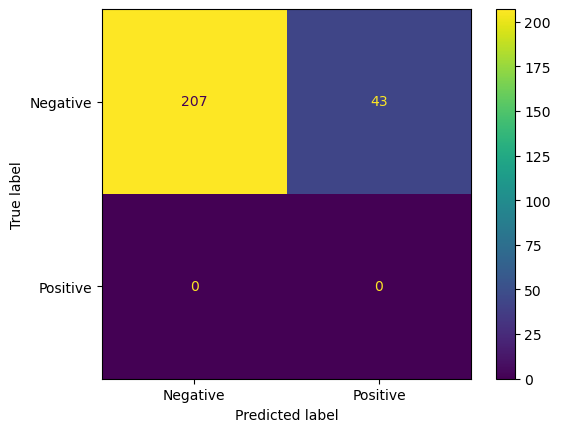

In [11]:
compute_confusion_matrix(y_true, y_pred, cfg.fig_path, cfg.dpi)

In [12]:
new_text = [
    "That movie was absolutely fantastic!",
    "I will never watch this again!",
    "Highly recommend to never watch again.",
    "Fantastic movie",
    "I kept wondering when it would be over.",
    "You couldn't pay me to watch it again."
]
inputs = inst.load_tokenizer(new_text)

model.eval()
with tc.no_grad():
    outputs = model(**inputs)
    
probs = tc.nn.functional.softmax(outputs.logits.to("cpu"), dim=-1)
predicted_classes = tc.argmax(probs, dim=-1)
labels = ["negative", "positive"]

for text, pred_idx, prob in zip(new_text, predicted_classes, probs):
    print(f"Text: '{text}'")
    print(f"Probabilities: {prob}")
    print(f"Predicted sentiment: {labels[pred_idx]} ({prob[pred_idx].item():.2f} confidence)\n")

Text: 'That movie was absolutely fantastic!'
Probabilities: tensor([0.0454, 0.9546])
Predicted sentiment: positive (0.95 confidence)

Text: 'I will never watch this again!'
Probabilities: tensor([0.7860, 0.2140])
Predicted sentiment: negative (0.79 confidence)

Text: 'Highly recommend to never watch again.'
Probabilities: tensor([0.3029, 0.6971])
Predicted sentiment: positive (0.70 confidence)

Text: 'Fantastic movie'
Probabilities: tensor([0.1142, 0.8858])
Predicted sentiment: positive (0.89 confidence)

Text: 'I kept wondering when it would be over.'
Probabilities: tensor([0.7454, 0.2546])
Predicted sentiment: negative (0.75 confidence)

Text: 'You couldn't pay me to watch it again.'
Probabilities: tensor([0.8822, 0.1178])
Predicted sentiment: negative (0.88 confidence)

